# Here we will do some analysis of the E. coli K12 reference genome

Rokhsar


In [77]:
# we will be using a data handling library called pandas
# which is basically a python spreadsheet

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline


# the other plotting library is seaborn - we'll use both during the class

import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

import statsmodels.formula.api as smf # basic statistical modeling

# Part 1. Poking around an annotation file

Read in the E coli genome in "FASTA" format
(Originally obtained from NCBI)

In [78]:
annot = pd.read_csv("~/Downloads/E_coli_K12_ProteinTable167_161521.txt",sep='\t')
annot.head(10)

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX
5,chr,NC_000913.3,5683,6459,-,944749,yaaA,b0006,NP_414547.1,258,-,peroxide stress resistance protein YaaA
6,chr,NC_000913.3,6529,7959,-,944745,yaaJ,b0007,NP_414548.1,476,-,putative transporter YaaJ
7,chr,NC_000913.3,8238,9191,+,944748,talB,b0008,NP_414549.1,317,-,transaldolase B
8,chr,NC_000913.3,9306,9893,+,944760,mog,b0009,NP_414550.1,195,-,molybdopterin adenylyltransferase
9,chr,NC_000913.3,9928,10494,-,944792,satP,b0010,NP_414551.1,188,-,acetate/succinate:H(+) symporter


In [79]:
# how many genes (rows)
annot.shape

(4242, 12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae517ec2e8>]],
      dtype=object)

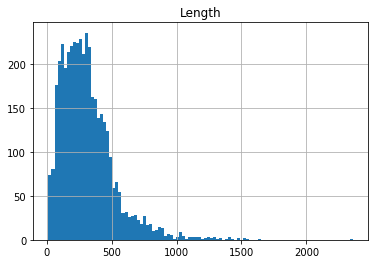

In [80]:
# simple question: what is the distribution of peptide lengths
annot.hist(column="Length", bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae90eff9e8>]],
      dtype=object)

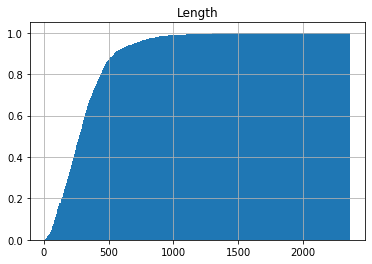

In [81]:
# sometimes its useful to do a cumulative plot
# what fraction of the genes have lengths less than x?
annot.hist(column ='Length', cumulative=True, density=1, bins=300)

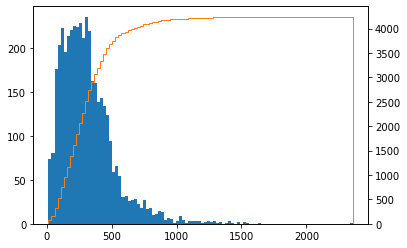

In [82]:
#combine them
fig, ax = plt.subplots()
ax2 = ax.twinx()
n, bins, patches = ax.hist(annot["Length"], bins=100)
n, bins, patches = ax2.hist(
    annot["Length"], cumulative=1, histtype='step', bins=100, color='tab:orange')
plt.savefig('test.png')

### Question
What is a common name for the x at which the cumulative distribution is 50% of the total?

#### distribution of genes along the chromosome

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae91069f60>]],
      dtype=object)

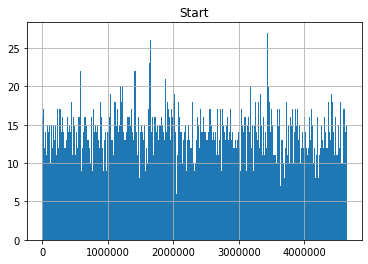

In [83]:
# what about the distribution of genes along the chromosome?
annot.hist(column="Start", bins=300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae5172d438>]],
      dtype=object)

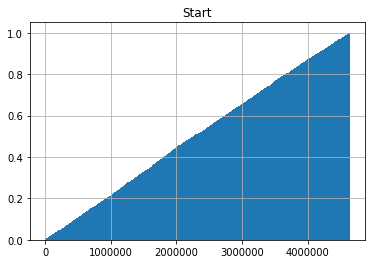

In [84]:
# cumulative sum of number of genes < position?
annot.hist(column=['Start'], cumulative=True, density=1, bins=300)

### here cumulative is not so useful ...
we'll consider this again later

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae48af89b0>]],
      dtype=object)

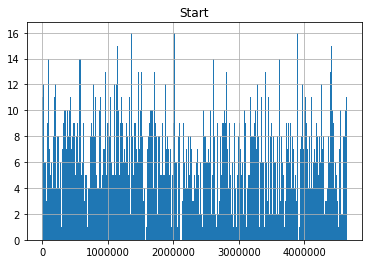

In [85]:
# positive strand usage across the chromosome
annot[annot.Strand == "+"].hist(column="Start", bins=300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae80ea3160>]],
      dtype=object)

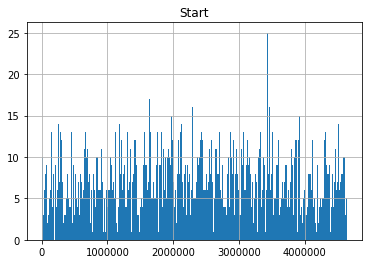

In [86]:
# negative strand usage
annot[annot.Strand == "-"].hist(column="Start", bins=300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae8122e6d8>]],
      dtype=object)

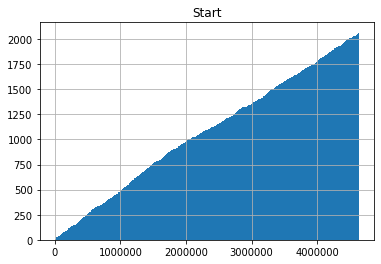

In [87]:
#  looking at cumulative, there appears to be a change in slope?
annot[annot.Strand == "+"].hist(column="Start", bins=300, cumulative=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae71151160>]],
      dtype=object)

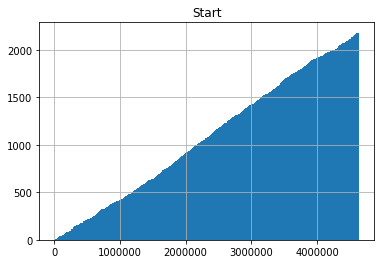

In [14]:
annot[annot.Strand == "-"].hist(column="Start", bins=300, cumulative=True)

In [89]:
# how many genes are on "+" vs "-" strands?
print("positive strand genes:",annot.Strand[annot.Strand == "+"].count())
print("negative strand genes:",annot.GeneID[annot.Strand == "-"].count())

positive strand genes: 2063
negative strand genes: 2179


# Part 2: starting to work with sequence

#### clumsy way to parse a fasta file: read in the rows of the fasta file into a data frame then loop over rows and concatenate the entries

In [90]:
genome_by_line = pd.read_csv("~/Downloads/E_coli_K12-sequence.fasta.txt")
genome_by_line.head()

,>NC_000913.3 Escherichia coli str. K-12 substr. MG1655,complete genome
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN


In [91]:
# How big is the data frame?
genome_by_line.shape

(66310, 2)

In [93]:
# how long is each line?
len(genome_by_line.iloc[10][0])

70

In [17]:
# there is no fixed convention, sometimes its 60, 70, 80.  
# Doesn't need to be the same in each row to be a well-formed FASTA file

In [94]:
# in fact the last line is shorter:
len(genome_by_line.iloc[66309][0])

22

In [20]:
# so the genome size is 
66309*70+22

4641652

In [95]:
# the original columns had names inherited randomly from the FASTA file
genome_by_line.columns

Index(['>NC_000913.3 Escherichia coli str. K-12 substr. MG1655', ' complete genome'], dtype='object')

In [96]:
#reset them
genome_by_line.columns = ["line", "empty"]

In [97]:
genome_by_line.iloc[0]["line"]

'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGC'

In [98]:
genome_by_line.head()

,line,empty
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN


In [99]:
# TRY TO drop the meaningless empty column (columns are axis=1)
lines = genome_by_line.drop("empty", axis=1)
lines.head()

,line
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...


In [100]:
lines.shape

(66310, 1)

In [27]:
lines.iloc[2][0]

'TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACC'

In [27]:
# HMM  This is no longer a string, it is an object ...
# go back to the original ...

In [28]:
#each element of "line" column is a (character) string
genome_by_line.iloc[0]["line"]

'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGC'

In [105]:
"A'C"    +     'BD'

"A'CBD"

In [29]:
# concatenating strings
genome_by_line.iloc[0]["line"]+genome_by_line.iloc[1]["line"]

'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAA'

In [110]:
# counting occurrences of a character in a line
genome_by_line.iloc[0]["line"].count("G")

17

In [31]:
len(genome_by_line.iloc[0]["line"])

70

In [164]:
genome_by_line.head()

,line,empty,GC_pct,Start,GC_skew
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN,0.414286,0,0.172414
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN,0.314286,70,-0.090909
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN,0.414286,140,-0.241379
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN,0.500000,210,-0.142857
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN,0.500000,280,0.028571


In [113]:
# do an operation line-by-line -- lets calculate local GC percentage
genome_by_line.apply(
    lambda row: (row["line"].count("G") + row["line"].count("C")) / len(row["line"]), axis=1
    ).head()

0    0.414286
1    0.314286
2    0.414286
3    0.500000
4    0.500000
dtype: float64

In [168]:
genome_by_line.apply(
    lambda x: (print (x["line"].count("G") > 20)), axis=1
    ).head()

False
False
False
False
False
False
False
False
True
False
True
False
True
True
True
True
False
False
True
False
False
True
True
False
False
True
False
False
False
False
False
False
False
True
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
False
True
False
True
False
True
False
True
False
False
False
False
True
False
True
True
False
True
True
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
False
False
False
True
False
False
False
False
True
False
False
False
True
True
False
False
False
True
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
True
True
True
False
False
False
False
False
True
True
False
False
True
True
False
False
False
True
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
F

False
False
False
False
False
False
False
False
False
True
False
True
True
True
True
False
False
False
True
True
False
False
True
True
True
True
True
False
False
False
True
False
False
True
True
False
True
True
True
False
True
True
True
False
True
True
True
True
True
False
False
False
True
False
False
True
True
False
True
False
True
False
True
False
False
True
False
True
False
True
False
True
False
True
False
True
True
False
True
True
False
True
True
True
True
False
True
True
True
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
True
True
False
False
False
False
False
True
True
True
True
True
True
True
False
True
False
True
True
False
True
False
False
True
False
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
Fals

True
False
True
True
False
False
True
False
True
True
True
False
False
True
True
True
False
False
False
False
False
False
True
False
False
False
True
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
True
True
False
False
False
False
True
False
False
False
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
True
True
False
False
False
False
True
True
False
False
True
False
False
False
False
False
True
True
False
True
True
False
True
True
False
True
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
F

True
False
False
False
False
True
False
True
True
False
False
False
False
True
False
False
False
False
False
False
True
False
True
False
True
True
True
False
False
False
True
True
False
False
True
False
False
False
False
False
True
False
False
True
False
True
False
False
False
False
False
True
True
True
True
False
False
False
False
False
True
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
True
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
True
True
False
True
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
F

False
False
True
False
False
False
True
True
True
True
True
False
False
False
False
True
True
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
True
False
True
False
False
False
True
False
False
True
False
False
False
True
True
False
False
False
False
False
False
True
False
False
True
True
True
False
False
False
False
False
True
False
False
False
True
False
False
True
False
True
False
False
True
True
False
True
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
True
False
False
False
False
True
True
False
False
True
False
F

False
False
False
False
False
False
False
False
False
False
True
False
True
False
True
False
False
False
False
False
True
False
False
False
False
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
False
True
True
False
True
False
True
False
True
True
False
False
False
True
False
False
False
True
False
True
False
True
True
False
False
False
False
False
True
False
True
False
True
False
False
False
False
False
False
True
True
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
True
True
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
True
False
False
False
True
True
True
False
True
False
True
True
True
True
True
True
False
True
True
True
True
True
True
True
False
True
False
False
True
True
False
True
False
False
True
True
True
False
True
True
False
False
False
False
False
True
False
True
True
False
True


False
False
False
True
False
True
False
True
False
False
False
False
False
False
False
True
True
False
True
False
False
False
True
False
False
False
False
False
False
False
True
False
True
True
True
True
True
False
False
False
False
False
False
False
True
False
False
False
True
True
True
True
True
True
False
True
True
False
False
False
False
False
False
False
True
True
True
False
False
False
False
True
True
True
False
False
True
False
True
False
False
False
False
True
False
True
False
False
False
False
True
True
False
True
True
False
True
True
False
True
True
True
False
True
False
True
True
True
False
True
False
True
False
True
False
False
False
True
True
False
False
False
True
False
False
True
True
False
True
False
True
True
False
False
True
False
False
True
False
True
False
False
False
False
False
False
True
True
False
False
True
False
False
False
True
True
False
True
True
False
True
True
False
False
False
False
False
False
False
True
True
True
True
False
False
False
True
False
False

False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
True
True
True
False
False
False
False
False
True
False
True
True
False
False
False
True
False
True
False
False
False
True
False
False
True
False
False
True
False
False
False
True
True
False
False
False
True
False
True
True
True
False
False
True
True
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
True
False
False
False
False
True
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
True
True
True
False
False
False
True
False
True
True
False
True
True
True
False
False
False
False
True
False
False
False
False
False
True
True
False
True
False
False
False
False
False
True
False
False
True
True
False
False
False
True
True
True
False
False
True
True
True
False
False
False
True
False
False
False
True
False
False
False
True
False
False
False
False
True
False
T

False
False
False
False
True
False
False
True
False
True
False
False
False
False
False
True
True
False
False
False
False
False
False
False
True
True
False
True
False
False
False
True
False
True
True
True
True
True
False
False
False
False
False
True
False
True
True
True
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
True
True
True
False
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
True
False
True
False
False
True
False
False
False
True
False
False
False
True
True
True
True
False
False
False
True
False
True
True
True
False
False
False
True
False
False
True
True
False
False
True
False
True
True
False
True
True
False
True
True
True
True
True
False
False
True
False
False
False
True
False
False
False
False
True
False
True
False
True
True
False
False
False
True
False
False
True
False
False
False
True
False
True
False
True
True

False
False
True
True
False
False
False
False
False
True
False
True
True
True
True
True
False
False
False
False
False
True
False
False
False
True
False
False
True
True
False
True
False
False
False
False
False
True
False
False
False
False
False
False
True
False
True
False
False
True
False
False
True
False
False
True
True
False
True
True
False
True
False
False
True
False
True
False
True
False
True
False
False
True
False
True
True
True
True
True
True
False
False
True
True
True
True
False
True
True
False
True
True
True
True
True
False
True
False
True
True
False
True
True
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
True
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
True
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
False
False
False
False
True
False
False
False
False
False
True
True
False
False
True
False
False
False
True
True
True
True
True
True
False
True
True
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
True
False
False
False
False
False
True
True
False
False
False
False
True
False
False
False
True
False
False
True
True
False
True
False
True
True
True
True
True
False
True
True
False
True
True
True
False
True
False
False
True
True
True
False
False
False
True
True
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
Fal

False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
True
False
True
True
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
True
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
True
True
False
False
False
False
True
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
True
True
True
False
False
False
False
True
False
False
False
F

False
True
True
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
True
False
False
False
False
False
False
False
True
True
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
True
False
True
False
True
True
False
True
True
False
False
True
True
False
False
False
False
False
True
False
True
True
True
True
False
False
False
False
True
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
True
False
True
False
True
False
False
True
False
False
False
False
False
True
False
False
True
False
False
False
False
False
True
True
False
True
False
False
False
False
False
False
True
False
True
False
False
False
False
True
False
False
False
False
False

False
False
False
False
False
True
True
True
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
True
True
False
False
True
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
True
True
False
False
False
True
False
False
True
False
True
False
False
True
False
True
True
False
False
False
True
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
True
True
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
True
False
False
True
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
True
True
False
False
False
False
False
True
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
Fa

False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
True
True
False
False
True
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
True
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
True
False
False
False
False
False
False
False
False
True
True
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
T

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
False
True
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
False
True
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
True
True
False
False
False
False
True
False
False
True
False
False
False
False
True
True
False
False
False
False
False
False
True
True
False
False
False
True
False
False
True
True
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True


False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
True
True
False
False
True
False
False
False
True
False
True
False
True
False
True
False
False
True
False
False
False
True
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
False
True
False
False
False
True
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

False
False
False
True
False
False
True
True
True
False
False
False
False
True
False
False
True
True
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
True
False
False
False
False
False
False
True
False
False
True
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
False
True
False
False
True
False
False
False
True
True
False
False
False
True
False
False
True
False
False
False
True
True
True
True
False
True
False
False
False
True
False
False
False
True
False
False
False
False
False
False
True
True
False
False
True
False
False
False
False
False
True
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
True
True
True
False
False
False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
True
False
True
False
True
False
False
False
False
False
False
False
False
True
True
True
False
False
True
True
False
False
True
False
True
False
False
True
True
False
False
False
False
False
True
False
False
False
False
True
True
False
False
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
True
False
True
True
False
False
False
False
True
True
True
False
True
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
True
False
False
False
False
False
False
Tr

False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
True
False
False
True
True
False
True
True
False
True
True
False
False
True
False
True
True
False
False
False
False
True
True
False
False
False
False
True
True
True
False
True
True
True
True
True
False
False
True
False
False
True
True
True
False
True
False
True
True
False
True
True
True
True
True
True
True
False
False
True
True
False
True
False
True
True
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
True
True
True
True
True
True
True
False
False
False
False
False
Fal

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
True
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
True
True
False
True
True
True
True
False
False
False
False
False
False
True
True
False
False
True
True
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
True
False

False
False
False
False
False
False
True
False
False
False
False
False
True
True
False
True
False
False
True
True
True
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


False
False
False
False
False
False
False
False
False
True
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
True
False
True
False
False
True
True
True
False
False
False
False
False
True
False
False
True
True
False
True
False
False
True
True
True
False
False
True
False
False
True
True
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
True
False
True
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
True
True
False
True
False
True
False
False
False
False
False
False
True
False
False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
Tr

False
False
False
True
False
False
True
False
True
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
True
False
False
True
True
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
False
True
False
False
False
False
False
False
False
False
False
True
False
True
False
True
False
T

False
False
False
False
True
False
False
False
True
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
True
False
True
False
True
False
True
False
False
False
False
True
True
False
False
False
False
False
False
False
True
True
False
False
False
True
False
True
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
True
False
True
True
False
False
False
True
False
False
False
False
False
False
False
True
True
False
True
False
True
False
True
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
True
False
False
False
False
False
True
True
True
False
True
Fals

False
False
False
False
False
False
False
False
True
True
False
False
True
True
True
False
False
True
False
True
False
True
True
False
False
False
True
True
False
False
False
True
False
False
False
False
True
False
False
False
False
True
True
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
True
False
False
False
True
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
True
True
False
False
False
False
False
True
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
True
False
False
False
False
False
False
False
True
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
True
False
False
True
False
False
True
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
True
False
False
True
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
True
True
False
False
False
False
True
False
True
True
False
True
False
True
False
True
False
False
False
True
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
True
F

False
False
False
False
False
True
False
False
True
True
False
False
False
True
False
False
False
False
True
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
True
False
False
True
True
True
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
True
False
True
False
False
True
False
False
False
True
True
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
F

False
False
True
True
False
False
False
True
True
False
False
True
False
False
True
False
True
False
True
False
False
False
True
False
False
False
False
True
True
True
True
False
False
False
True
True
False
False
True
False
True
True
True
False
True
True
False
False
False
False
True
False
False
False
True
False
True
False
False
False
False
False
True
True
False
True
False
True
True
True
True
False
False
False
True
False
False
False
True
False
False
True
False
True
True
True
True
True
False
False
False
False
True
True
False
True
False
False
False
False
True
False
False
False
True
True
False
False
False
False
False
False
False
False
True
False
False
True
True
False
True
False
True
True
True
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
True
True
False
True
False
True
True
True
False
False
True
False
True
False
False
True
False
False
True
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
True
False
True
False
True
False
False
False
False
True
True
True
True
True
False
False
False
False
True
True
False
False
True
False
True
True
True
False
False
False
False
False
False
False
True
True
True
True
False
False
False
False
True
False
True
False
True
True
True
False
False
False
False
False
False
False
False
True
False
False
True
False
False
True
False
True
False
False
True
True
False
False
True
True
False
True
True
False
True
False
False
True
True
False
False
True
True
True
True
False
False
True
True
False
True
False
True
False
True
True
True
False
True
False
False
False
False
False
True
True
True
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
False
False
False
True
False
True
False
False
False
True
True
False
True
False
False
False
False
False

False
False
False
True
True
True
False
False
False
True
False
False
False
False
False
False
False
True
True
True
False
True
False
False
True
False
False
True
True
True
False
True
True
True
False
False
True
True
True
True
True
True
False
False
True
False
False
False
True
True
True
False
True
False
True
True
True
True
True
True
False
False
False
True
True
False
False
True
False
True
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
True
False
True
False
True
True
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
True
False
False
True
False
True
False
False
False
False
False
False
True
True
False
False
False
True
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
True
True
False
False
True
False
True
False
False
False
False
True
False
False
False
False
True
True
False
True


False
True
False
False
False
False
True
True
True
False
False
False
True
True
False
False
False
False
False
False
True
False
False
True
True
False
True
True
True
False
True
True
True
False
True
False
False
True
True
False
False
True
False
False
False
True
False
False
True
False
False
False
True
True
True
False
True
False
False
False
True
False
False
False
False
False
False
False
True
False
False
True
False
True
False
False
True
False
False
False
True
True
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
True
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
T

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
True
False
False
True
False
False
True
False
False
True
True
False
False
False
True
False
True
False
False
False
False
False
False
False
True
False
True
False
True
False
False
True
True
False
False
False
True
True
False
True
False
False
True
False
False
True
False
True
False
False
False
False
True
True
False
True
False
True
False
False
True
False
True
False
True
True
False
False
True
True
False
True
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
True
False
False
False
True
False
False
False
True
False
False
True
False
True
False
True
False
True
False
False
True
False
True
True
False
False
False
False
True
True
True
True
False
False
True
False
False
True
False
False
False
False
True
False
False
False
False
False
True
False
False
Tru

0    None
1    None
2    None
3    None
4    None
dtype: object

In [114]:
# now create a new column
genome_by_line["GC_pct"] = genome_by_line.apply(
    lambda row: (row["line"].count("G") + row["line"].count("C"))/ len(row["line"]), axis=1)

In [115]:
genome_by_line.head()

,line,empty,GC_pct
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN,0.414286
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN,0.314286
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN,0.414286
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN,0.500000
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN,0.500000


In [116]:
# need to also add a column indicating the position in the genome
# increment by 70.
genome_by_line["Start"] = 0
genome_by_line.head()

,line,empty,GC_pct,Start
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN,0.414286,0
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN,0.314286,0
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN,0.414286,0
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN,0.500000,0
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN,0.500000,0


In [117]:
# add a column that is 70 x index
for i in range(0, len(genome_by_line)):
    genome_by_line["Start"][i] = i*70

In [118]:
genome_by_line.head()

,line,empty,GC_pct,Start
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN,0.414286,0
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN,0.314286,70
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN,0.414286,140
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN,0.500000,210
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN,0.500000,280


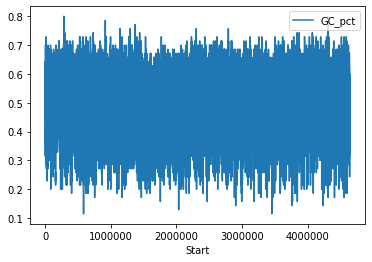

In [121]:
# now we have two columns we can plot to look at the variation in GC
genome_by_line.plot(x='Start',y="GC_pct")

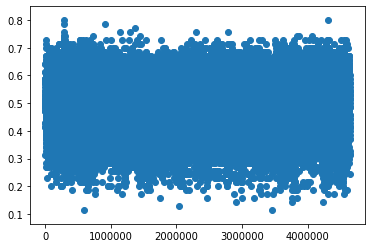

In [122]:
import matplotlib.pyplot as plt
plt.scatter(genome_by_line['Start'], genome_by_line['GC_pct'])
plt.show() # Depending on whether you use IPython or interactive mode, etc.


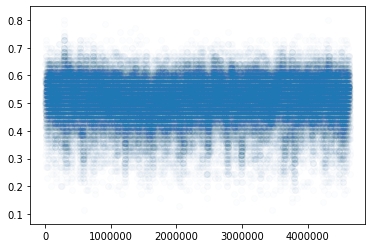

In [123]:
# these dots lie on top of each other, so lets make them transparent ("alpha")
import matplotlib.pyplot as plt
plt.scatter(genome_by_line['Start'], genome_by_line['GC_pct'], 
            alpha=0.01)
plt.show() # Depending on whether you use IPython or interactive mode, etc.



#### so GC content sees fairly stable across the genome, although there are some extreme excursion (e.g., GC content as low as 10% and as high as 80%.


In [128]:
genome_by_line["GC_pct"].describe()

count    66310.000000
mean         0.507905
std          0.080612
min          0.114286
25%          0.457143
50%          0.514286
75%          0.557143
max          0.800000
Name: GC_pct, dtype: float64

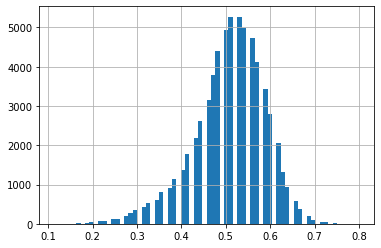

In [43]:
genome_by_line["GC_pct"].hist(bins = 70)

In [43]:
# question: why is it so choppy?

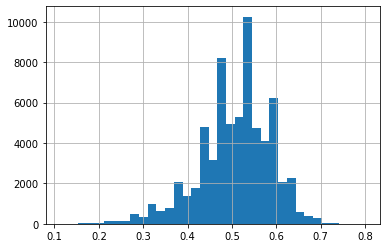

In [137]:
genome_by_line["GC_pct"].hist(bins = 35)

/Users/drokhsar/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


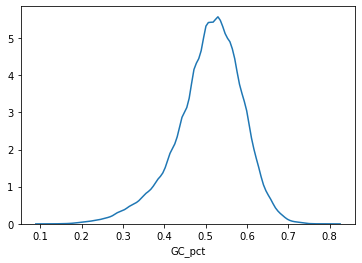

In [136]:
# rather than mess around with picking the right number of bins, 
# can also use "kernel density estimator" that smooths the distribution
sns.distplot(genome_by_line["GC_pct"], hist=False)

# we can also look at "G-C", called the "skew"

In [138]:
# now create a new column (G-C)/(G+C)
genome_by_line["GC_skew"] = genome_by_line.apply(
    lambda row: (row["line"].count("G") - row["line"].count("C"))/ (row["line"].count("G") + row["line"].count("C")), axis=1)

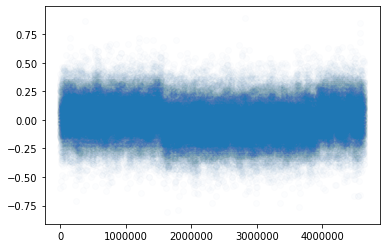

In [139]:
import matplotlib.pyplot as plt
plt.scatter(genome_by_line['Start'], genome_by_line['GC_skew'], 
            alpha=0.01)
plt.show() # Depending on whether you use IPython or interactive mode, etc.



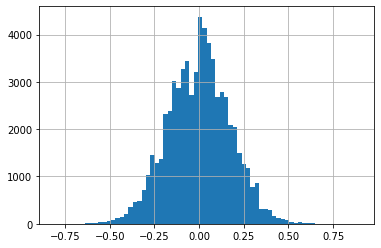

In [140]:
# now there is a subtle but non-trivial variation along the genome.
# there is still a lot of variation row to row (since each row is only 70 bp)
genome_by_line["GC_skew"].hist(bins = 70)

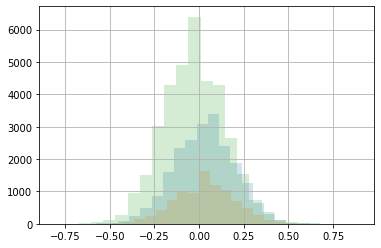

In [143]:
# make two histograms
genome_by_line[genome_by_line.Start < 1500000]["GC_skew"].hist(bins = 25, alpha = 0.2)
genome_by_line[genome_by_line.Start > 4000000]["GC_skew"].hist(bins = 25, alpha = 0.2)
genome_by_line[(4000000 > genome_by_line.Start) & (genome_by_line.Start > 1500000)]["GC_skew"].hist(bins = 25, alpha = 0.2)

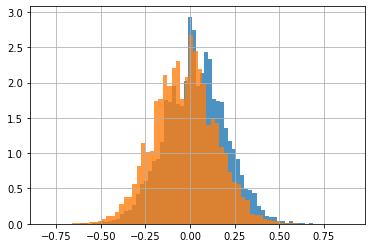

In [144]:
#but there are more orange genes than blue genes.  
# So "normalize" => show probability (frequency) distribution rather than counts
genome_by_line[genome_by_line.Start < 1500000]["GC_skew"].hist(bins = 70, alpha = 0.8, density=True)
genome_by_line[(4000000 > genome_by_line.Start) &
        (genome_by_line.Start > 1500000)]["GC_skew"].hist(bins = 70, alpha = 0.8, density=True)

In [51]:
genome_by_line[genome_by_line.Start < 1500000]["GC_skew"].describe()

count    21429.000000
mean         0.032722
std          0.169796
min         -0.705882
25%         -0.081081
50%          0.030303
75%          0.142857
max          0.866667
Name: GC_skew, dtype: float64

In [52]:
genome_by_line[(4000000 > genome_by_line.Start) &
       (genome_by_line.Start > 1500000)]["GC_skew"].describe()

count    35714.000000
mean        -0.029069
std          0.171641
min         -0.809524
25%         -0.142857
50%         -0.028571
75%          0.085714
max          0.894737
Name: GC_skew, dtype: float64

In [53]:
#difference of means
genome_by_line[genome_by_line.Start < 1500000]["GC_skew"].mean()-genome_by_line[(4000000 > genome_by_line.Start) &
       (genome_by_line.Start > 1500000)]["GC_skew"].mean()

0.061790723062151075

In [54]:
# so there appears to be a difference in skew in the first 1.5Mb of the genome (blue) 
# relative to 1.5-4Mb (orange). But it is subtle.
# How can we find the point at which it changes?  (and then changes back ...)
# look at the cumulative!

In [55]:
genome_by_line.head()

,line,empty,GC_pct,Start,GC_skew
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN,0.414286,0,0.172414
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN,0.314286,70,-0.090909
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN,0.414286,140,-0.241379
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN,0.500000,210,-0.142857
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN,0.500000,280,0.028571


In [145]:
# make a simplified dataframe
df = genome_by_line[["Start","GC_skew"]]

In [146]:
df.head()

,Start,GC_skew
0,0,0.172414
1,70,-0.090909
2,140,-0.241379
3,210,-0.142857
4,280,0.028571


In [58]:
df.iloc[0]["GC_skew"]

0.1724137931034483

In [147]:
newcol = []
cumulative = 0
for i in range(0, len(df)):
    cumulative = cumulative + df.iloc[i]["GC_skew"]
    newcol.append(cumulative)
print(newcol[10])

-0.21408167410784212


In [149]:
df["GC_skew_cum"]=newcol
df.head()

,Start,GC_skew,GC_skew_cum
0,0,0.172414,0.172414
1,70,-0.090909,0.081505
2,140,-0.241379,-0.159875
3,210,-0.142857,-0.302732
4,280,0.028571,-0.274160


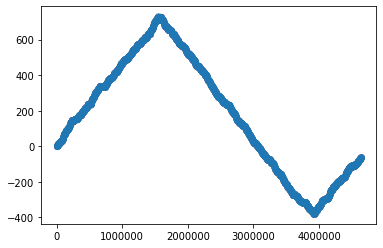

In [150]:
import matplotlib.pyplot as plt
plt.scatter(df['Start'], df['GC_skew_cum'], alpha=0.01)
plt.show() # Depending on whether you use IPython or interactive mode, etc.

In [151]:
# maximum value
df["GC_skew_cum"].max()

731.4081431332255

In [152]:
# where is it?
df["GC_skew_cum"].idxmax()

22176

In [64]:
# this is the row number (index)
# what is the position?
df.iloc[df["GC_skew_cum"].idxmax()]

Start          1.552320e+06
GC_skew        1.250000e-01
GC_skew_cum    7.314081e+02
Name: 22176, dtype: float64

In [65]:
# same for minimum
print(df["GC_skew_cum"].min())
df.iloc[df["GC_skew_cum"].idxmin()]

-380.0801612532452


Start          3.925530e+06
GC_skew       -1.739130e-01
GC_skew_cum   -3.800802e+02
Name: 56079, dtype: float64

# exercise: do the same thing for local strand usage 

# Part 3. Working with the entire genome in a single string

In [66]:
# Now lets make a single large string with the entire genome in it, by concatenating rows
genome = ""
for index, row in genome_by_line.iterrows():
    genome = genome + row[0]   

In [67]:
len(genome)

4641652

In [68]:
genome[0:100]

'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT'

In [69]:
genome_by_line.count()

line       66310
empty          0
GC_pct     66310
Start      66310
GC_skew    66310
dtype: int64

In [153]:
# dictionary of DNA letters
DNA_letters = {"A":0,"C":1,"G":2,"T":3}
Cumulative = {"A":0,"C":0,"G":0,"T":0}


In [154]:
DNA_letters["C"]

1

In [155]:
for i in range(0,len(genome)):
    nucleotide = genome[i]
    Cumulative[nucleotide] +=1

In [156]:
Cumulative

{'A': 1142742, 'C': 1180091, 'G': 1177437, 'T': 1141382}

In [73]:
# look at the first gene
annot.iloc[0]

#Replicon Name                              chr
Replicon Accession                  NC_000913.3
Start                                       190
Stop                                        255
Strand                                        +
GeneID                                   944742
Locus                                      thrL
Locus tag                                 b0001
Protein product                     NP_414542.1
Length                                       21
COG(s)                                        -
Protein name          thr operon leader peptide
Name: 0, dtype: object

In [157]:
# start at 190, stop at 255
genome[190:255]

'TGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA'

In [160]:
# but this does not start with ATG.  it is an off-by-one problem
# python labels first entry "0", but this table counts the first 
# nucleotide in the genome as "1"
# solution: subtract 1 from the "start" when using it to access nucleotide

# Question: why don't we have to do the same for the stop?
print(genome[189:255])
len(genome[189:255])

ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA


66

# Operons!

In [77]:
# groupby (strand, and operon name) shorten gene name to keep first three letter. 

In [75]:
import copy
test_df =copy.copy(annot)
test_df.head()

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX


In [179]:
test_df['oper_name'] = test_df.Locus.apply(lambda x: x[:3])

#test_df.groupby()
test_df.groupby(['oper_name','Strand']).count()["Start"]

oper_name  Strand
aae        +         1
           -         3
aas        -         1
aat        -         1
abg        +         1
           -         3
abp        -         2
abr        -         1
acc        +         3
           -         1
ace        +         5
ack        +         1
acn        +         2
acp        +         2
           -         2
acr        +         5
           -         2
acs        -         1
act        -         1
ada        -         1
add        +         1
ade        +         1
           -         2
adh        -         2
adi        -         3
adk        +         1
aeg        -         1
aer        -         1
aes        -         1
afu        -         1
                    ..
yrh        +         2
ysa        -         2
ysd        +         1
ysg        -         1
ysh        -         1
ytc        -         1
ytf        +         7
           -         5
yth        +         1
yti        +         2
           -         1
ytj        +    